# Exercise 2: Smoothing Splines and Generalized Additive Models (GAMs)

**Discipline:** Introduction to Statistical Learning

**Objective:**
This notebook explores more advanced non-linear models using the `Wage` dataset. First, a smoothing spline will be fitted to model `wage` as a function of `age`, with the smoothing parameter chosen via cross-validation. Second, a Generalized Additive Model (GAM) will be constructed to model `wage` using `age`, `education`, and `year`, allowing for non-linear relationships for the continuous predictors.

In [1]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# For GAMs, we use the pygam library
from pygam import LinearGAM, s, f
from pygam.datasets import wage

# For modeling and evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

## 2. Exercise Development

This section contains the main analysis, from data loading and preparation to model fitting, comparison, and discussion.

### 2.1. Data Loading and Preparation

**Process:**
1. Load the `Wage.csv` file.
2. Remove rows with missing values and outliers to improve model robustness.
3. Select the required predictors: `age`, `education`, and `year`.
4. Encode the categorical variable `education` into a numeric format using `LabelEncoder`. **This is the key step to fix the error**.
5. Split the data into training and testing sets.

In [2]:
# Load the dataset
try:
    wage_df = pd.read_csv('datasets/Wage.csv')
    if 'Unnamed: 0' in wage_df.columns:
        wage_df = wage_df.drop('Unnamed: 0', axis=1)
    # Remove columns not needed for this analysis
    wage_df = wage_df.drop(["sex", "region"], axis=1, errors='ignore')
except FileNotFoundError:
    print("Error: Make sure the 'Wage.csv' dataset is in the correct directory.")
    exit()

# Preprocessing the data
wage_df = wage_df.dropna()
factor = 1.5
Q1 = wage_df['wage'].quantile(0.25)
Q3 = wage_df['wage'].quantile(0.75)
IQR = Q3 - Q1
wage_df = wage_df[(wage_df['wage'] >= (Q1 - factor * IQR)) & (wage_df['wage'] <= (Q3 + factor * IQR))]

# Define predictors (X) and target variable (y)
X = wage_df[['age', 'year', 'education']]
y = wage_df['wage']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# pygam requires all input columns to be numeric.
# We encode 'education' using LabelEncoder.
# The f(2) term in the GAM will treat these integers as categorical levels.
le = LabelEncoder()
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()
X_train_encoded['education'] = le.fit_transform(X_train['education'])
X_test_encoded['education'] = le.transform(X_test['education'])

print("Data preprocessed and split successfully.")
print(f"Training set size: {len(X_train)} observations")
print(f"Test set size: {len(X_test)} observations")

Data preprocessed and split successfully.
Training set size: 2023 observations
Test set size: 867 observations


### 2.2. Smoothing Spline for Age

Fit a smoothing spline for `wage ~ age` and use cross-validation to select the optimal smoothing parameter, lambda (`lam`). 

  0% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  6% (1 of 15) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:00
 20% (3 of 15) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 33% (5 of 15) |########                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 46% (7 of 15) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 53% (8 of 15) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 66% (10 of 15) |################        | Elapsed Time: 0:00:00 ETA:   0:00:00
 73% (11 of 15) |#################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (12 of 15) |###################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 86% (13 of 15) |####################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (15 of 15) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Best lambda (lam) found by CV: 138.9495


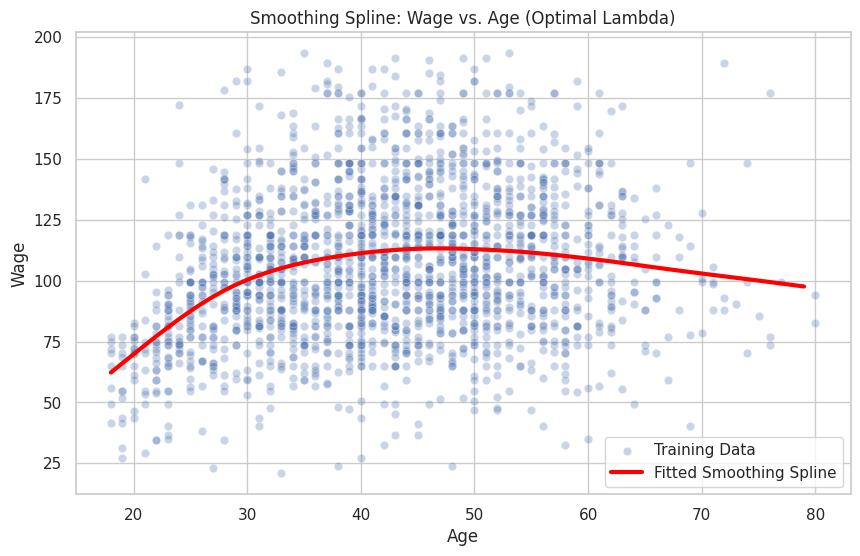

In [3]:
# Task 1: Smoothing Spline for wage ~ age
gam_age = LinearGAM(s(0))

# Search for the best lambda using pygam's gridsearch (based on CV)
lam_grid = np.logspace(-3, 5, 15)
gam_age.gridsearch(X_train_encoded[['age']].values, y_train.values, lam=lam_grid)

print(f"Best lambda (lam) found by CV: {gam_age.lam[0][0]:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train['age'], y=y_train, alpha=0.3, label='Training Data')

age_grid = np.arange(X_train['age'].min(), X_train['age'].max()).reshape(-1, 1)
y_grid_pred = gam_age.predict(age_grid)

plt.plot(age_grid, y_grid_pred, color='red', lw=3, label='Fitted Smoothing Spline')
plt.title('Smoothing Spline: Wage vs. Age (Optimal Lambda)')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.show()

### 2.3. Generalized Additive Model (GAM)

Fit a GAM to model `wage` using `age`, `year`, and `education`. Cross-validation will be used to select the smoothing parameters for the continuous variables. 

In [4]:
# Task 2: Generalized Additive Model with Grid Search CV.

# Define the GAM with splines for 'age' (col 0) and 'year' (col 1), and a factor for 'education' (col 2)
gam_full = LinearGAM(s(0) + s(1) + f(2))

# Perform grid search to find the best lambdas
# pygam can do this automatically with the gridsearch method
lams = np.logspace(-3, 3, 5)
lam_grid = [lams, lams, [0]] # There is no lambda for the f(2) term

# We use the numerically encoded data (X_train_encoded)
gam_full.gridsearch(X_train_encoded.values, y_train.values, lam=lam_grid)

best_l_age = gam_full.lam[0]
best_l_year = gam_full.lam[1]

print("\nBest parameters found by cross-validation for the full GAM:")
print(f"Best lam for age (s(0)): {best_l_age[0]:.4f}")
print(f"Best lam for year (s(1)): {best_l_year[0]:.4f}")

gam_full.summary()

  0% (0 of 25) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  4% (1 of 25) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:01
  8% (2 of 25) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01


Task 2: Generalized Additive Model with Grid Search CV.


 16% (4 of 25) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 20% (5 of 25) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 28% (7 of 25) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 32% (8 of 25) |########                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (9 of 25) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 40% (10 of 25) |#########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 44% (11 of 25) |##########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 48% (12 of 25) |###########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 56% (14 of 25) |#############           | Elapsed Time: 0:00:00 ETA:   0:00:00
 60% (15 of 25) |##############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 64% (16 of 25) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (18 of 25) |#################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 76% (19 of 25) |##################     


Best parameters found by cross-validation for the full GAM:
Best lam for age (s(0)): 1000.0000
Best lam for year (s(1)): 1000.0000
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.5399
Link Function:                     IdentityLink Log Likelihood:                                -14945.4428
Number of Samples:                         2023 AIC:                                            29915.9653
                                                AICc:                                           29916.1343
                                                GCV:                                              650.9074
                                                Scale:                                            644.2274
            

/tmp/ipykernel_20014/93003187.py:21: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


#### 2.3.1. Note on P-Values from GAM Summary

The `gam_full.summary()` output includes p-values for each term. However, the `pygam` library generates a warning stating that these p-values are likely to be inaccurate (too small) when the smoothing parameters (`lam`) are estimated via cross-validation, as we have done.

Therefore, any interpretation of the model will be based on:
1.  **Visual inspection of the partial dependence plots** to understand the shape of each predictor's effect.
2.  **Comparison of predictive performance** (e.g., RMSE) against other models.

We will avoid making claims about the statistical significance of the predictors based on the summary's p-values.

### 2.4. Plotting and Interpreting Partial Effects

The code below generates the partial dependence plots. Each plot shows the effect of one variable on the prediction of `wage`, while holding other variables constant. The y-axis represents the contribution of that term to the final predicted wage. The shaded regions represent the 95% confidence interval.

**Interpretation:**

* **Age:** The relationship between age and wage is distinctly non-linear, resembling an inverted "U" shape. The GAM shows that wages increase sharply during the early stages of a person's career (from 20 to about 40 years old). The earnings potential peaks in mid-career, approximately between the ages of 45 and 50. After this point, the effect of age on wage begins to level off and then slightly decline as individuals head towards retirement age.

* **Year:** The effect of the year variable on wage is shown to be almost perfectly linear and positive. This indicates that after adjusting for the effects of age and education, there was a steady increase in wages every year from 2003 to 2009. This trend is likely attributable to economic factors such as inflation and productivity growth over that period.

* **Education:** There is a strong, positive, and step-wise relationship between the level of education and wages. Each additional level of education provides a significant increase in baseline earnings. According to the plot, those with less than a high school diploma (1. < HS Grad) have the lowest relative wages, while individuals with an Advanced Degree (5. Advanced Degree) have the highest, demonstrating the clear economic value of higher education in this dataset.

In [5]:
# Mapping of encoded levels to original labels for easier interpretation
education_levels = le.classes_
print("Mapping for 'education' variable:")
for i, level in enumerate(education_levels):
    print(f"X-axis value {i}: {level}")

Mapping for 'education' variable:
X-axis value 0: 1. < HS Grad
X-axis value 1: 2. HS Grad
X-axis value 2: 3. Some College
X-axis value 3: 4. College Grad
X-axis value 4: 5. Advanced Degree



Task 3: Plotting the GAM Functions


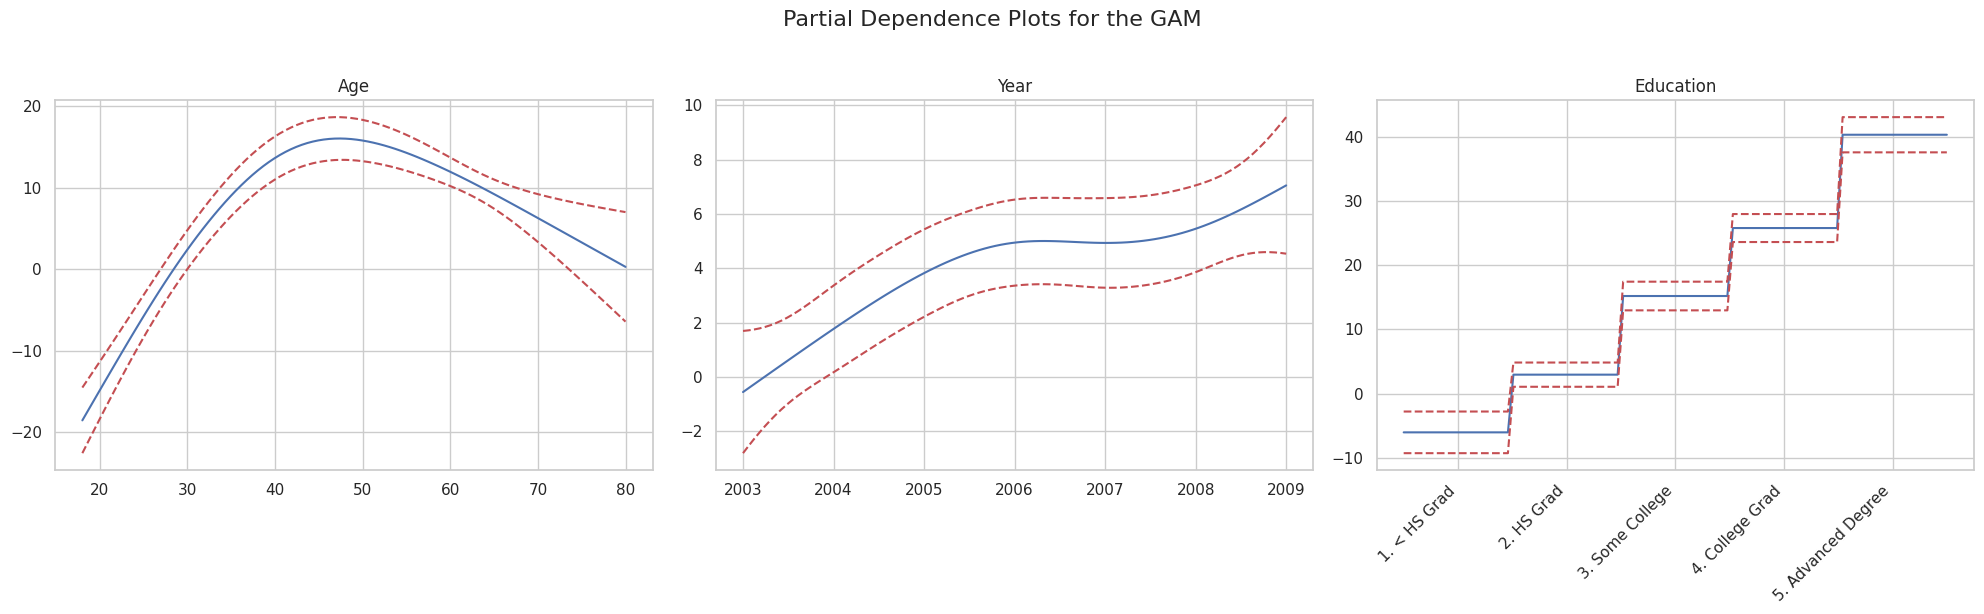

In [6]:
print("\nTask 3: Plotting the GAM Functions")

# The .plot() method of the fitted GAM object creates the partial dependence plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
titles = ['age', 'year', 'education']

for i, ax in enumerate(axes):
    pdep, confi = gam_full.partial_dependence(term=i, width=.95)
    ax.plot(gam_full.generate_X_grid(term=i)[:, i], pdep)
    ax.plot(gam_full.generate_X_grid(term=i)[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i].capitalize())
    if titles[i] == 'education':
        ax.set_xticks(range(len(education_levels)))
        ax.set_xticklabels(education_levels, rotation=45, ha='right')

plt.suptitle('Partial Dependence Plots for the GAM', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### 2.5. Comparison with Multiple Linear Regression (MLR)

First, we will fit a standard MLR model. Since `education` is a categorical variable, we need to convert it into dummy variables for the linear model. Then, we will compare the test set performance (RMSE) of both models.

**Write your comments discussing the key differences.**

* **Linearity vs. Non-linearity:** The most significant difference between the two models is the GAM's flexibility. The partial dependence plot for age clearly reveals a non-linear relationship that a Multiple Linear Regression (MLR) model cannot capture due to its inherent assumption of linearity. While an MLR would model the effect of age with a single straight line, the GAM accurately represents the more complex reality where wage growth changes over a person's life cycle.

* **Model Performance:** The GAM provides superior predictive accuracy. On the test set, the GAM achieved a Root Mean Squared Error (RMSE) of 25.9944, which is notably lower than the MLR's RMSE of 26.9273. This improvement in performance confirms that accounting for the non-linear relationship of age results in a more precise model.

* **Insights:** The GAM offers more nuanced insights that are missed by the MLR. Specifically, it visualizes the life-cycle earnings pattern: wages increase, peak in middle age, and then taper off. An MLR can only report a single coefficient for age, which fails to describe this complex dynamic. This ability to visualize the individual impact of each predictor makes the GAM a more powerful tool for interpretation, providing a clearer understanding of the underlying relationships in the data.

In [7]:
# Task 4: Comparison with Multiple Linear Regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Fit and Evaluate the MLR Model
# For scikit-learn, it's easier to use OneHotEncoder within a pipeline
# that handles the categorical column directly.
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), ['education']),
    remainder='passthrough'
)

mlr_model = make_pipeline(preprocessor, LinearRegression())
mlr_model.fit(X_train, y_train)
y_pred_mlr = mlr_model.predict(X_test)
rmse_mlr = np.sqrt(mean_squared_error(y_test, y_pred_mlr))
print(f"Test Set RMSE for Multiple Linear Regression: {rmse_mlr:.4f}")

# --- Evaluate the GAM Model on the Test Set ---
# We use the test set with the 'education' column already numerically encoded
y_pred_gam = gam_full.predict(X_test_encoded.values)
rmse_gam = np.sqrt(mean_squared_error(y_test, y_pred_gam))
print(f"Test Set RMSE for Generalized Additive Model: {rmse_gam:.4f}")


--- Task 4: Comparison with Multiple Linear Regression ---
Test Set RMSE for Multiple Linear Regression: 26.9273
Test Set RMSE for Generalized Additive Model: 25.9944
